In [37]:
import dlib
import cv2
from skimage import io
import numpy as np
import matplotlib.pyplot as plt

# Facial Landmark detection

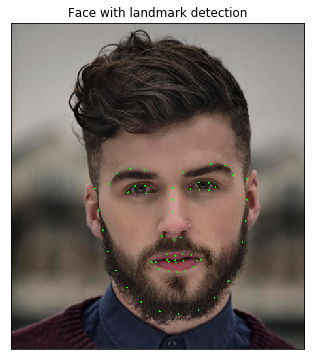

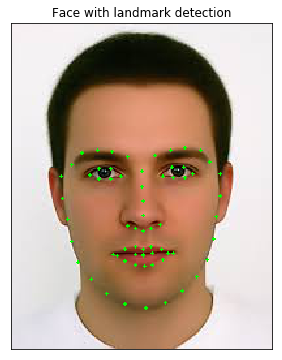

In [46]:
def get_facial_landmarks(predictor_path, image_path):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(predictor_path)
    image = io.imread(image_path)
    dets = detector(image, 1)
    #print("Number of faces detected: {}".format(len(dets)))
    for k, d in enumerate(dets):
        #print("Detection {}: Left: {} Top: {} Right: {} Bottom: {}".format(k, d.left(), d.top(), d.right(), d.bottom()))
        shape = predictor(image, d)       
    vec = np.empty([68, 2], dtype = int)
    for b in range(68):
        vec[b][0] = shape.part(b).x
        vec[b][1] = shape.part(b).y
    return vec

def show_facial_landmarks(landmarks, image_path):
    img = cv2.imread(image_path)
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    for landmark in landmarks:
        cv2.circle(image, (landmark[0], landmark[1]), 1, (0,255,0), -1)
    
    fig = plt.figure(figsize=(6, 6,))
    ax1 = fig.add_subplot(111)
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    ax1.set_title('Face with landmark detection')
    ax1.imshow(image)
    return None

#source_img = './img/source-face.jpeg'
source_img = './img/imag1.jpg'
#target_img = './img/target-face.jpeg'
target_img = './img/source-face.jpeg'
predictor_path = './../detector_architectures/shape_predictor_68_face_landmarks.dat'

source_landmarks = get_facial_landmarks(predictor_path, source_img)
target_landmarks = get_facial_landmarks(predictor_path, target_img)

show_facial_landmarks(source_landmarks, source_img)
show_facial_landmarks(target_landmarks, target_img)

# Convex hull

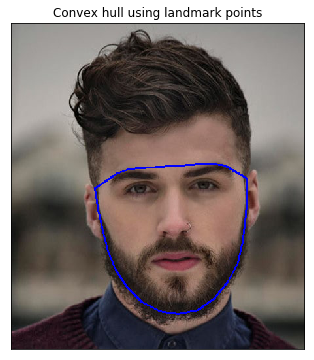

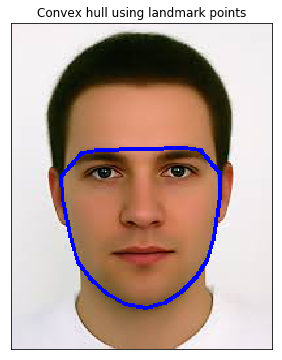

In [47]:
def get_convex_hull(points):
    return cv2.convexHull(points)
    
def draw_convex_hull(points, image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    filler = get_convex_hull(points)
    cv2.drawContours(img, [filler], -1, (0,0,255), 2)
    fig = plt.figure(figsize=(6, 6,))
    ax1 = fig.add_subplot(111)
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    ax1.set_title('Convex hull using landmark points')
    ax1.imshow(img)
    return None

draw_convex_hull(source_landmarks, source_img)
draw_convex_hull(target_landmarks, target_img)

# Delaunay triangulation

In [48]:
def fix_points(landmarks):
    points = []
    for chpoints in get_convex_hull(landmarks):
        for point in chpoints:
            points.append([point[0], point[1]])
    return points 

source_points = fix_points(source_landmarks)
target_points = fix_points(target_landmarks)

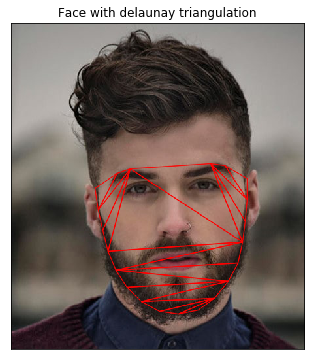

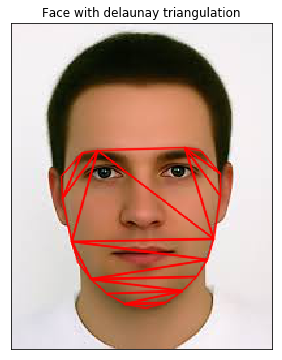

In [49]:
def rect_contains(rect, points):
    if points[0] < rect[0]: return False
    elif points[1] < rect[1]: return False
    elif points[0] > rect[2]: return False
    elif points[1] > rect[3]: return False
    return True

def get_delaunay_triangulation(image_path, points):
    img = cv2.imread(image_path)
    rect = (0, 0, img.shape[1], img.shape[0])
    subdiv = cv2.Subdiv2D(rect)
    for point in points:
        subdiv.insert((point[0], point[1]))
    
    triangleList = subdiv.getTriangleList()
    delaunay = []
    for t in triangleList:
        pt = []
        pt.append((t[0], t[1]))
        pt.append((t[2], t[3]))
        pt.append((t[4], t[5]))
        
        pt1 = (t[0],t[1])
        pt2 = (t[2],t[3])
        pt3 = (t[4],t[5])
        if rect_contains(rect, pt1) and rect_contains(rect, pt2) and rect_contains(rect, pt3):
            ind = []
            for j in range(0, 3):
                for k in range(0, len(points)):
                    if(abs(pt[j][0] - points[k][0]) < 1. and abs(pt[j][1] - points[k][1]) < 1.):
                        ind.append(k)
            if len(ind) == 3:
                delaunay.append((points[ind[0]], points[ind[1]], points[ind[2]]))
    return delaunay

def totuple(a):
    try:
        return tuple(totuple(i) for i in a)
    except TypeError:
        return a
    
def draw_delaunay_triangulation(delaunay, image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for point in delaunay:
        pt1 = totuple(point[0])
        pt2 = totuple(point[1])
        pt3 = totuple(point[2])
        cv2.line(img, pt1, pt2, (255,0,0), 1, cv2.LINE_AA, 0)
        cv2.line(img, pt2, pt3, (255,0,0), 1, cv2.LINE_AA, 0)
        cv2.line(img, pt3, pt1, (255,0,0), 1, cv2.LINE_AA, 0)
    fig = plt.figure(figsize=(6, 6,))
    ax1 = fig.add_subplot(111)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_title('Face with delaunay triangulation')
    ax1.imshow(img)

source_delaunay_points = get_delaunay_triangulation(source_img, source_points)
target_delaunay_points = get_delaunay_triangulation(target_img, target_points)

draw_delaunay_triangulation(source_delaunay_points, source_img)
draw_delaunay_triangulation(target_delaunay_points, target_img)

# Affine warp triangles

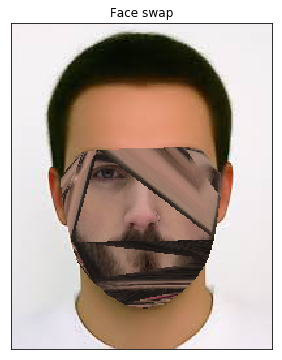

In [51]:

img1 = cv2.imread(source_img)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.imread(target_img)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

for triangles in zip(source_delaunay_points, target_delaunay_points):
    src_tri = np.float32([triangles[0]])
    dst_tri = np.float32([triangles[1]])
    
    # Find bounding rectangle for each triangle
    r1 = cv2.boundingRect(src_tri)
    r2 = cv2.boundingRect(dst_tri)
    # Crop images and change coordinates 
    src_tri_cropped = []
    dst_tri_cropped = []
    
    for i in range(0,3):
        src_tri_cropped.append(( (src_tri[0][i][0] - r1[0]), (src_tri[0][i][1] - r1[1]) ))
        dst_tri_cropped.append(( (dst_tri[0][i][0] - r2[0]), (dst_tri[0][i][1] - r2[1]) ))
    
    src_img_cropped = img1[ r1[1]:r1[1]+r1[3], r1[0]:r1[0]+r1[2]]
    # Estimate the affine transform
    warp_mat = cv2.getAffineTransform(np.float32(src_tri_cropped), np.float32(dst_tri_cropped))
    # Warp pixels inside bounding box
    dst_img_cropped = cv2.warpAffine(src_img_cropped, warp_mat, (r2[2], r2[3]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)
    # Mask pixels outside the triangle 
    mask = np.zeros((r2[3], r2[2], 3), dtype=np.float32)
    
    cv2.fillConvexPoly(mask, np.int32(dst_tri_cropped), (1.,1.,1.), 16, 0)
    dst_img_cropped = dst_img_cropped * mask
    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] * ( (1.0, 1.0, 1.0) - mask )
    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] + dst_img_cropped
    

fig = plt.figure(figsize=(6, 6,))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Face swap')
ax1.imshow(img2)
